=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===


DRIVING DURATION: 30 min driving/day
P(driving at seizure time) = 0.5/24 = 0.0208

1 seizure / week (baseline seizure prob = 0.1331)
  30 min driving/day
-------------------------------------------------------
  AUC = 0.60: FPR = 1.000, Sensitivity = 1.000
     Days in warning per year: 365.0
     Days allowed to drive per year: 0.0
     Average interval between driving days: 5828507.1 days

  AUC = 0.80: FPR = 0.702, Sensitivity = 0.957
     Days in warning per year: 268.7
     Days allowed to drive per year: 96.3
     Average interval between driving days: 3.8 days

  AUC = 0.90: FPR = 0.298, Sensitivity = 0.900
     Days in warning per year: 138.0
     Days allowed to drive per year: 227.0
     Average interval between driving days: 1.6 days


1 seizure / month (baseline seizure prob = 0.0328)
  30 min driving/day
-------------------------------------------------------
  AUC = 0.60: FPR = 0.659, Sensitivity = 0.7

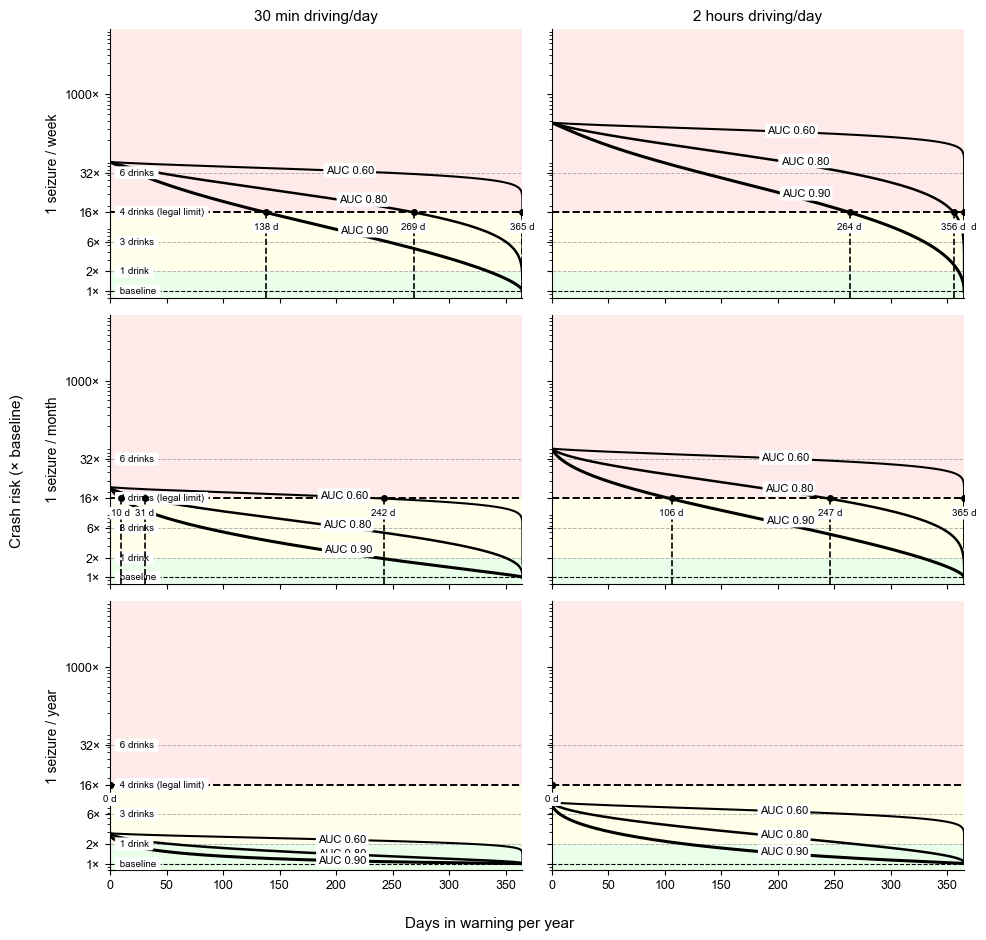

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -------------------------------------------------
# Global style
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
})

# -------------------------
# Configuration
# -------------------------
R = [1/7, 1/30, 1/365]
R_labels = ['1 seizure / week', '1 seizure / month', '1 seizure / year']

# Driving durations (hours per day)
driving_hours_list = [0.5, 2.0]
driving_labels = ['30 min driving/day', '2 hours driving/day']

# Updated AUC values
auc_values = [0.60, 0.80, 0.90]
auc_linewidth = {0.60: 1.5, 0.80: 1.8, 0.90: 2.2}

# Reference crash risks (baseline sober risk p0)
p0 = 1.5e-5
p1 = p0 * 2**(0.02/0.02)   # 1 drink
p3 = p0 * 2**(0.05/0.02)   # 3 drinks
p4 = p0 * 2**(0.08/0.02)   # 4 drinks (legal limit)
p6 = p0 * 2**(0.12/0.02)   # 6 drinks

y_limits = [0.8, 1e4]
p_crash_given_seizure_while_driving = 0.5  # P(crash | seizure occurs while driving)

# -------------------------
# Helper
# -------------------------
def compute_curve_for_auc(auc, p_seizure, driving_hours):
    """Return days_warning, pc_relative, sensitivity, FPR for given AUC, daily seizure prob, and driving hours."""
    m = np.sqrt(2) * norm.ppf(auc)
    th = np.linspace(-10, 10, 1000)

    s_ana = norm.cdf(m - th)      # sensitivity
    f_ana = 1 - norm.cdf(th)      # FPR

    num = norm.cdf(th - m) * p_seizure
    den = num + norm.cdf(th) * (1 - p_seizure)
    pn_ana = num / den            # P(seizure | "safe" day)

    p_warning = s_ana * p_seizure + f_ana * (1 - p_seizure)
    days_warning = p_warning * 365

    # Updated crash model:
    # P(driving at time of seizure) = driving_hours / 24
    # P(crash | seizure day) = P(driving at seizure) * P(crash | seizure while driving) 
    #                        + P(not driving at seizure) * p0
    p_driving_at_seizure = driving_hours / 24
    p_crash_given_seizure_day = (p_driving_at_seizure * p_crash_given_seizure_while_driving 
                                  + (1 - p_driving_at_seizure) * p0)
    
    # P(crash | "safe" day) = P(seizure | safe) * P(crash | seizure day) + P(no seizure | safe) * p0
    pc_ana = pn_ana * p_crash_given_seizure_day + (1 - pn_ana) * p0
    pc_relative = pc_ana / p0

    return days_warning, pc_relative, s_ana, f_ana

# -------------------------
# Figure: 3 rows (seizure freq) × 2 cols (driving duration)
# -------------------------
fig, axes = plt.subplots(3, 2, figsize=(10, 9.5), sharex=True, sharey=True)

print('=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===\n')

for col, driving_hours in enumerate(driving_hours_list):
    print(f'\n{"="*60}')
    print(f'DRIVING DURATION: {driving_labels[col]}')
    print(f'P(driving at seizure time) = {driving_hours}/24 = {driving_hours/24:.4f}')
    print(f'{"="*60}\n')
    
    for row, r in enumerate(R):
        ax = axes[row, col]
        
        # Baseline daily seizure probability (Poisson process)
        p = 1 - np.exp(-r)
        
        print(f'{R_labels[row]} (baseline seizure prob = {p:.4f})')
        print(f'  {driving_labels[col]}')
        print('-' * 55)

        # Light-pink shaded "unsafe" region above legal limit (4 drinks)
        ax.axhspan(p4/p0, y_limits[1],
                   facecolor='#ffcccc', alpha=0.4, zorder=0)
        
        # Light-yellow shaded region between 1 drink and 4 drinks (legal limit)
        ax.axhspan(p1/p0, p4/p0,
                   facecolor='#ffffcc', alpha=0.4, zorder=0)
        
        # Light-green shaded "safe" region below 1 drink
        ax.axhspan(y_limits[0], p1/p0,
                   facecolor='#ccffcc', alpha=0.4, zorder=0)

        # Horizontal reference lines
        ax.axhline(y=1,       color='k',        linestyle='--', linewidth=0.8, zorder=1)
        ax.axhline(y=p1/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
        ax.axhline(y=p3/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
        ax.axhline(y=p4/p0,   color='black',    linestyle='--', linewidth=1.4, zorder=2)
        ax.axhline(y=p6/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)

        # Store crossing info for later labeling (to ensure labels are on top)
        crossing_info = []

        # Curves for each AUC
        for auc in auc_values:
            days_warning, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, driving_hours)

            ax.plot(days_warning, pc_rel,
                    color='k', linewidth=auc_linewidth[auc], zorder=3)

            # Sort for cross detection
            idx_sort = np.argsort(days_warning)
            dw_sorted = days_warning[idx_sort]
            pc_sorted = pc_rel[idx_sort]
            s_sorted = s_ana[idx_sort]
            f_sorted = f_ana[idx_sort]

            # First point where crash risk drops below legal-limit threshold
            idx_cross = np.where(pc_sorted < p4/p0)[0]
            if len(idx_cross) > 0:
                idx_cross = idx_cross[0]
                dw_cross = dw_sorted[idx_cross]
                s_cross = s_sorted[idx_cross]
                f_cross = f_sorted[idx_cross]

                # Store for later plotting on top
                crossing_info.append((dw_cross, auc, s_cross, f_cross, p))

                # Text output for table / checking
                p_warning_cross = s_cross * p + f_cross * (1 - p)
                p_safe = 1 - p_warning_cross
                days_driving = p_safe * 365
                avg_interval = 1 / p_safe if p_safe > 0 else np.inf

                print(f'  AUC = {auc:.2f}: FPR = {f_cross:.3f}, Sensitivity = {s_cross:.3f}')
                print(f'     Days in warning per year: {dw_cross:.1f}')
                print(f'     Days allowed to drive per year: {days_driving:.1f}')
                print(f'     Average interval between driving days: {avg_interval:.1f} days\n')
            else:
                print(f'  AUC = {auc:.2f}: Cannot reach legal-limit safety threshold\n')

            # Label the curve around its median x
            mid_idx = np.argmin(np.abs(days_warning - np.median(days_warning)))
            ax.text(days_warning[mid_idx], pc_rel[mid_idx],
                    f'AUC {auc:.2f}',
                    fontsize=8, ha='left', va='center',
                    bbox=dict(boxstyle='round,pad=0.2',
                              facecolor='white', edgecolor='none'),
                    zorder=5)

        # Now plot crossing markers and labels ON TOP (highest z-order)
        for dw_cross, auc, s_cross, f_cross, p in crossing_info:
            # Vertical black dashed line
            ax.plot([dw_cross, dw_cross],
                    [y_limits[0], p4/p0],
                    'k--', linewidth=1.2, zorder=6)
            # Black marker at crossing point (smaller)
            ax.plot(dw_cross, p4/p0,
                    'o', color='black', markersize=4, zorder=7)

            # Label with number of warning days - ON TOP with opaque box
            ax.text(dw_cross, p4/p0*0.7,
                    f'{dw_cross:.0f} d',
                    fontsize=7, ha='center', va='top',
                    bbox=dict(boxstyle='round,pad=0.2',
                              facecolor='white', edgecolor='none', alpha=1.0),
                    zorder=8)

        # Panel formatting
        ax.set_ylim(y_limits)
        ax.set_xlim([0, 365])
        ax.set_yscale('log')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Row labels (seizure frequency) on left column only
        if col == 0:
            ax.set_ylabel(R_labels[row], fontsize=10)

        # Column labels (driving duration) on top row only
        if row == 0:
            ax.set_title(driving_labels[col], fontsize=11)

        # Drink labels (only on left column to reduce clutter)
        if col == 0:
            ax.text(6, 1,        ' baseline ',               fontsize=7, va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
                    zorder=5)
            ax.text(6, p1/p0,    ' 1 drink ',                fontsize=7, va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
                    zorder=5)
            ax.text(6, p3/p0,    ' 3 drinks ',               fontsize=7, va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
                    zorder=5)
            ax.text(6, p4/p0,    ' 4 drinks (legal limit) ', fontsize=7, va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
                    zorder=5)
            ax.text(6, p6/p0,    ' 6 drinks ',               fontsize=7, va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
                    zorder=5)

        # Intuitive y-ticks
        ax.set_yticks([1, p1/p0, p3/p0, p4/p0, p6/p0, 1e3])
        ax.set_yticklabels(['1×', '2×', '6×', '16×', '32×', '1000×'])

        print()

# Shared labels
fig.text(0.02, 0.5, 'Crash risk (× baseline)', va='center',
         rotation='vertical', fontsize=11)
fig.text(0.5, 0.02, 'Days in warning per year', ha='center', fontsize=11)

plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.08)

fig.savefig('Figure_S1.pdf', facecolor='white', bbox_inches='tight')
fig.savefig('Figure_S1.png', facecolor='white', bbox_inches='tight', dpi=300)

plt.show()

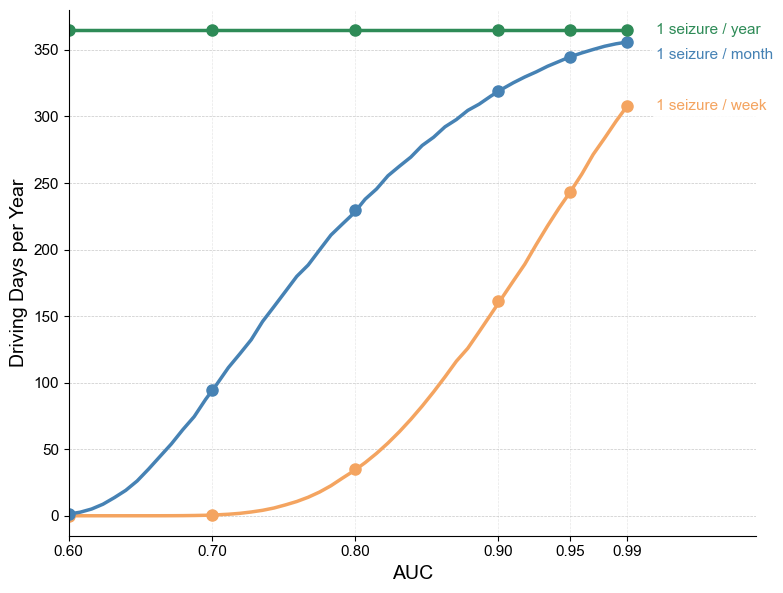


Figure 1 saved as Figure_1.pdf and Figure_1.png
Driving duration: 1.0 hour/day

DRIVING DAYS PER YEAR (at key AUC values):

1 seizure / week:
  AUC 0.60:    0.0 days/year
  AUC 0.70:    0.5 days/year
  AUC 0.80:   34.9 days/year
  AUC 0.90:  161.2 days/year
  AUC 0.95:  243.5 days/year
  AUC 0.99:  308.1 days/year

1 seizure / month:
  AUC 0.60:    1.3 days/year
  AUC 0.70:   94.3 days/year
  AUC 0.80:  230.0 days/year
  AUC 0.90:  319.3 days/year
  AUC 0.95:  344.9 days/year
  AUC 0.99:  356.0 days/year

1 seizure / year:
  AUC 0.60:  365.0 days/year
  AUC 0.70:  365.0 days/year
  AUC 0.80:  365.0 days/year
  AUC 0.90:  365.0 days/year
  AUC 0.95:  365.0 days/year
  AUC 0.99:  365.0 days/year


In [2]:
# -------------------------------------------------
# Figure 1: Driving Days/Year vs AUC (Main Text Figure)
# Single panel: 1 hour/day driving
# -------------------------------------------------

# AUC values for smooth curves
auc_grid_smooth = np.linspace(0.60, 0.99, 50)

# AUC values to show with markers
auc_grid_markers = np.array([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])

# Driving duration for main text figure
DRIVING_HOURS_MAIN = 1.0

# Colors for each seizure frequency
colors = {
    '1 seizure / week': '#F4A460',    # Sandy brown / orange
    '1 seizure / month': '#4682B4',   # Steel blue
    '1 seizure / year': '#2E8B57',    # Sea green
}

# Compute driving days
driving_days_smooth_1hr = {label: [] for label in R_labels}
driving_days_markers_1hr = {label: [] for label in R_labels}

for r, label in zip(R, R_labels):
    p = 1 - np.exp(-r)
    
    # Compute for smooth curve
    for auc in auc_grid_smooth:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, DRIVING_HOURS_MAIN)
        
        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]
        
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]
            
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
        else:
            days_driving = 0
        
        driving_days_smooth_1hr[label].append(days_driving)
    
    # Compute for marker points
    for auc in auc_grid_markers:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, DRIVING_HOURS_MAIN)
        
        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]
        
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]
            
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
        else:
            days_driving = 0
        
        driving_days_markers_1hr[label].append(days_driving)

# Create single-panel figure with Tufte-style inline labels
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
})

fig1, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot smooth curves
for label in R_labels:
    ax.plot(auc_grid_smooth, driving_days_smooth_1hr[label],
            linewidth=2.5, color=colors[label])

# Plot markers at key AUC values
for label in R_labels:
    ax.plot(auc_grid_markers, driving_days_markers_1hr[label],
            marker='o', markersize=8, linewidth=0,
            color=colors[label])

# Add inline labels directly on curves (at right end, Tufte style)
for label in R_labels:
    y = driving_days_markers_1hr[label][-1]
    
    # Manual offset for overlapping labels
    if label == '1 seizure / month':
        y -= 10  # Move down slightly to avoid overlap
    
    ax.text(0.995 + 0.015, y, label,
            fontsize=11, ha='left', va='center',
            color=colors[label],
            bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', 
                     edgecolor='none',
                     alpha=0.9))

# Formatting
ax.set_xlim(0.60, 1.08)  # Extended to make room for labels
ax.set_ylim(-15, 380)
ax.set_xlabel('AUC', fontsize=14)
ax.set_ylabel('Driving Days per Year', fontsize=14)

# Grid
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.3)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick formatting
ax.tick_params(axis='both', labelsize=11)
ax.set_xticks([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
ax.set_xticklabels(['0.60', '0.70', '0.80', '0.90', '0.95', '0.99'])
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350])

plt.tight_layout()

fig1.savefig('Figure_1.pdf', facecolor='white', bbox_inches='tight')
fig1.savefig('Figure_1.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

# Print statistics
print('\nFigure 1 saved as Figure_1.pdf and Figure_1.png')
print(f'Driving duration: {DRIVING_HOURS_MAIN} hour/day')
print('\n' + '='*70)
print('DRIVING DAYS PER YEAR (at key AUC values):')
print('='*70)
for label in R_labels:
    print(f'\n{label}:')
    for auc, days in zip(auc_grid_markers, driving_days_markers_1hr[label]):
        print(f'  AUC {auc:.2f}: {days:6.1f} days/year')


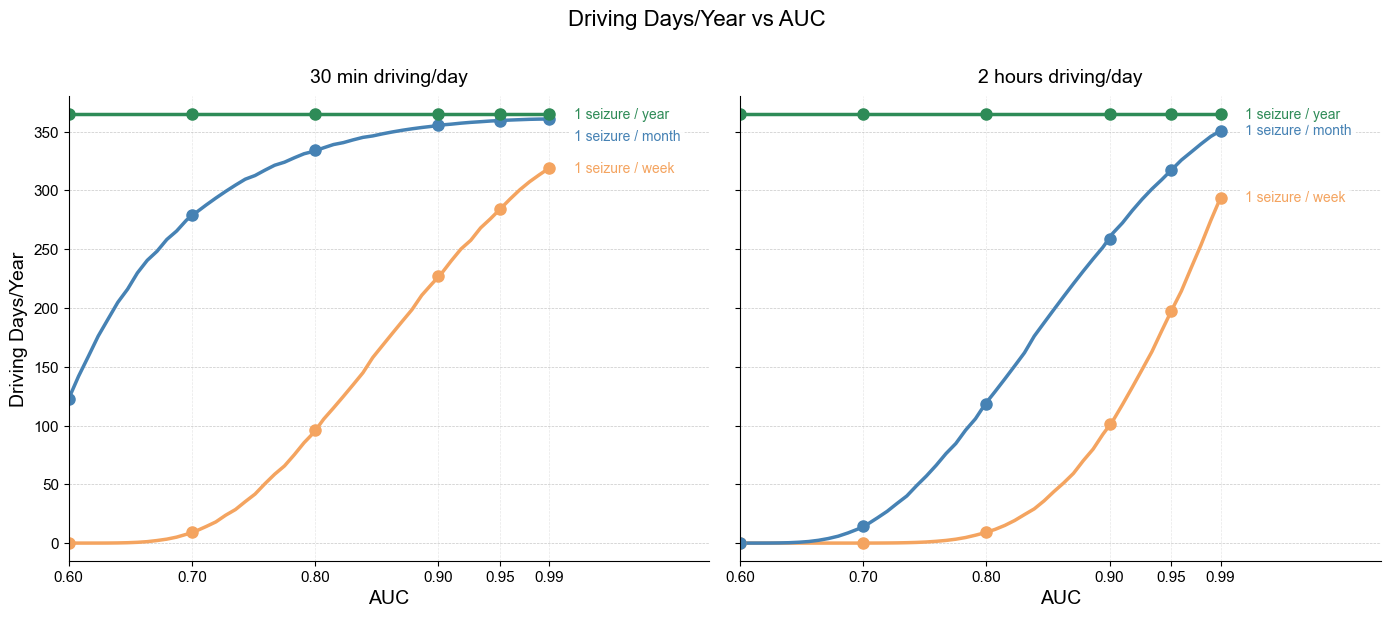


Figures saved as Figure_1.pdf and Figure_1.png

FIGURE LEGEND:

Figure 1. Annual driving days permitted under forecasting-based driving policy
to maintain crash risk below legal intoxication threshold (16× baseline).

Left panel: 30 minutes of driving per day. Right panel: 2 hours of driving per day.
Curves show the relationship between forecasting algorithm performance (AUC)
and the number of days per year a patient can safely drive for three seizure
frequencies. Filled circles mark key AUC values (0.60, 0.70, 0.80, 0.90, 0.95,
0.99). Curves are calculated analytically using the equal-variance binormal ROC
model with Bayes' theorem.

The model accounts for driving exposure: crash risk on a seizure day depends on
the probability that the seizure occurs while driving (driving hours / 24),
multiplied by P(crash | seizure while driving) = 0.5.



Driving Days Data (at marker points):

30 min driving/day:
------------------------------------------------------------
  1 seizure / week:
   

In [3]:
# -------------------------------------------------
# Figure: Driving Days/Year vs AUC (Main Text Figure)
# Two-panel: 30 min/day vs 2 hr/day
# -------------------------------------------------

# AUC values for smooth curves (many intermediate points)
auc_grid_smooth = np.linspace(0.60, 0.99, 50)

# AUC values to show with markers
auc_grid_markers = np.array([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])

# Driving durations
driving_hours_list = [0.5, 2.0]
driving_labels = ['30 min driving/day', '2 hours driving/day']

# Colors for each seizure frequency
colors = {
    '1 seizure / week': '#F4A460',    # Sandy brown / orange
    '1 seizure / month': '#4682B4',   # Steel blue
    '1 seizure / year': '#2E8B57',    # Sea green
}

# Compute driving days for smooth curves
driving_days_smooth = {dh: {label: [] for label in R_labels} for dh in driving_hours_list}
driving_days_markers = {dh: {label: [] for label in R_labels} for dh in driving_hours_list}

for driving_hours in driving_hours_list:
    for r, label in zip(R, R_labels):
        p = 1 - np.exp(-r)
        
        # Compute for smooth curve
        for auc in auc_grid_smooth:
            dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, driving_hours)
            
            idx_sort = np.argsort(dw)
            dw_sorted = dw[idx_sort]
            pc_sorted = pc_rel[idx_sort]
            s_sorted = s_ana[idx_sort]
            f_sorted = f_ana[idx_sort]
            
            idx_cross = np.where(pc_sorted < p4/p0)[0]
            if len(idx_cross) > 0:
                idx_cross = idx_cross[0]
                s_cross = s_sorted[idx_cross]
                f_cross = f_sorted[idx_cross]
                
                p_warning_cross = s_cross * p + f_cross * (1 - p)
                p_safe = 1 - p_warning_cross
                days_driving = p_safe * 365
            else:
                days_driving = 0
            
            driving_days_smooth[driving_hours][label].append(days_driving)
        
        # Compute for marker points
        for auc in auc_grid_markers:
            dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, driving_hours)
            
            idx_sort = np.argsort(dw)
            dw_sorted = dw[idx_sort]
            pc_sorted = pc_rel[idx_sort]
            s_sorted = s_ana[idx_sort]
            f_sorted = f_ana[idx_sort]
            
            idx_cross = np.where(pc_sorted < p4/p0)[0]
            if len(idx_cross) > 0:
                idx_cross = idx_cross[0]
                s_cross = s_sorted[idx_cross]
                f_cross = f_sorted[idx_cross]
                
                p_warning_cross = s_cross * p + f_cross * (1 - p)
                p_safe = 1 - p_warning_cross
                days_driving = p_safe * 365
            else:
                days_driving = 0
            
            driving_days_markers[driving_hours][label].append(days_driving)

# Create figure with Arial font
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
})

fig_main, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for col, driving_hours in enumerate(driving_hours_list):
    ax = axes[col]
    
    # Plot smooth curves
    for label in R_labels:
        ax.plot(auc_grid_smooth, driving_days_smooth[driving_hours][label],
                linewidth=2.5, color=colors[label])

    # Plot markers at key AUC values
    for label in R_labels:
        ax.plot(auc_grid_markers, driving_days_markers[driving_hours][label],
                marker='o', markersize=8, linewidth=0,
                color=colors[label])

    # Add inline labels directly on curves (at right end)
    for label in R_labels:
        y = driving_days_markers[driving_hours][label][-1]
        
        # Manual offset for overlapping labels in left panel
        if col == 0 and label == '1 seizure / month':
            y -= 15  # Move down to avoid overlap with "1 seizure / year"
        
        ax.text(0.995 + 0.015, y, label,
                fontsize=10, ha='left', va='center',
                color=colors[label],
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor='white', 
                         edgecolor='none',
                         alpha=0.9))

    # Formatting
    ax.set_xlim(0.60, 1.12)
    ax.set_ylim(-15, 380)
    ax.set_xlabel('AUC', fontsize=14)
    ax.set_title(driving_labels[col], fontsize=14, pad=10)

    # Grid
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.3)

    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Tick formatting
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xticks([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
    ax.set_xticklabels(['0.60', '0.70', '0.80', '0.90', '0.95', '0.99'])

# Y-axis label only on left panel
axes[0].set_ylabel('Driving Days/Year', fontsize=14)
axes[0].set_yticks([0, 50, 100, 150, 200, 250, 300, 350])

# Overall title
fig_main.suptitle('Driving Days/Year vs AUC', fontsize=16, y=1.02)

plt.tight_layout()

fig_main.savefig('Figure_S2.pdf', facecolor='white', bbox_inches='tight')
fig_main.savefig('Figure_S2.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

# Print figure legend
print('\nFigures saved as Figure_1.pdf and Figure_1.png')
print('\n' + '='*80)
print('FIGURE LEGEND:')
print('='*80)
print()
print('Figure 1. Annual driving days permitted under forecasting-based driving policy')
print('to maintain crash risk below legal intoxication threshold (16× baseline).')
print()
print('Left panel: 30 minutes of driving per day. Right panel: 2 hours of driving per day.')
print('Curves show the relationship between forecasting algorithm performance (AUC)')
print('and the number of days per year a patient can safely drive for three seizure')
print('frequencies. Filled circles mark key AUC values (0.60, 0.70, 0.80, 0.90, 0.95,')
print('0.99). Curves are calculated analytically using the equal-variance binormal ROC')
print('model with Bayes\' theorem.')
print()
print('The model accounts for driving exposure: crash risk on a seizure day depends on')
print('the probability that the seizure occurs while driving (driving hours / 24),')
print('multiplied by P(crash | seizure while driving) = 0.5.')
print()
print('='*80)
print()
print('\nDriving Days Data (at marker points):')
print('=' * 70)
for col, driving_hours in enumerate(driving_hours_list):
    print(f'\n{driving_labels[col]}:')
    print('-' * 60)
    for label in R_labels:
        print(f'  {label}:')
        for auc, days in zip(auc_grid_markers, driving_days_markers[driving_hours][label]):
            print(f'    AUC {auc:.2f}: {days:6.1f} days/year')

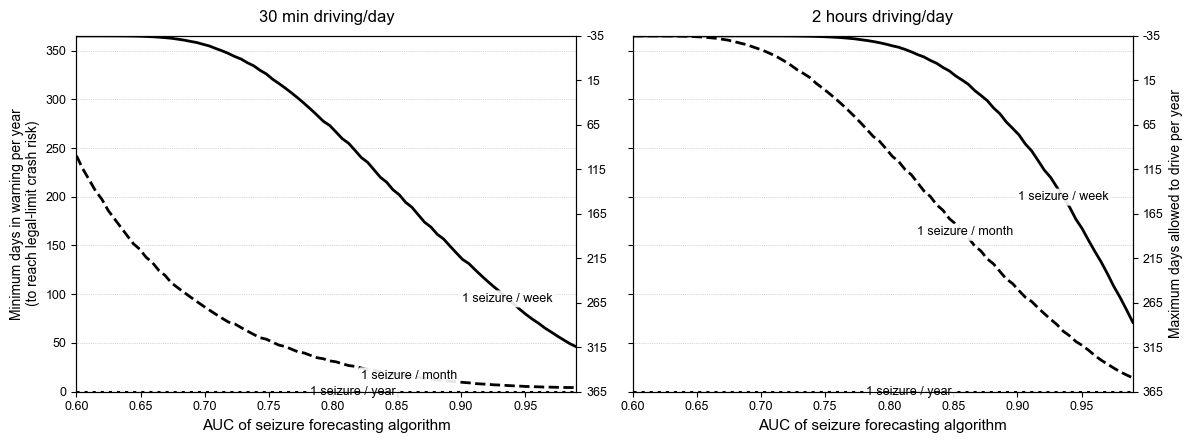

In [4]:
# -------------------------------------------------
# Figure S3: minimum warning days vs AUC (two-panel)
# -------------------------------------------------

# Driving durations
driving_hours_list = [0.5, 2.0]
driving_labels = ['30 min driving/day', '2 hours driving/day']

auc_grid = np.linspace(0.60, 0.99, 80)

# Compute minimum warning days for each driving duration
min_warning_days = {dh: {label: [] for label in R_labels} for dh in driving_hours_list}

for driving_hours in driving_hours_list:
    for r, label in zip(R, R_labels):
        p = 1 - np.exp(-r)
        for auc in auc_grid:
            dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, driving_hours)
            idx_sort = np.argsort(dw)
            dw_sorted = dw[idx_sort]
            pc_sorted = pc_rel[idx_sort]
            idx_cross = np.where(pc_sorted < p4/p0)[0]
            if len(idx_cross) > 0:
                min_dw = dw_sorted[idx_cross[0]]
            else:
                min_dw = np.nan
            min_warning_days[driving_hours][label].append(min_dw)

# Convert to arrays
for dh in driving_hours_list:
    for k in min_warning_days[dh]:
        min_warning_days[dh][k] = np.array(min_warning_days[dh][k])

# Create two-panel figure
fig2, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

styles = {
    '1 seizure / week':  ('-',  2.0),
    '1 seizure / month': ('--', 2.0),
    '1 seizure / year':  (':',  2.2),
}

# Label positions (fraction along valid AUC range)
label_frac = {
    '1 seizure / week': 0.85,
    '1 seizure / month': 0.65,
    '1 seizure / year': 0.55,
}

for col, driving_hours in enumerate(driving_hours_list):
    ax = axes[col]
    
    # Plot the three curves
    for label in R_labels:
        ls, lw = styles[label]
        ax.plot(auc_grid, min_warning_days[driving_hours][label],
                linestyle=ls, linewidth=lw, color='k')
    
    ax.set_xlim(0.60, 0.99)
    ax.set_ylim(0, 365)
    ax.set_xlabel('AUC of seizure forecasting algorithm', fontsize=11)
    ax.set_title(driving_labels[col], fontsize=12, pad=10)
    
    # Y-axis ticks
    ticks = np.arange(0, 401, 50)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 365)
    
    # Secondary y-axis (driving days)
    ax2b = ax.twinx()
    ax2b.set_ylim(0, 365)
    ax2b.set_yticks(ticks)
    ax2b.set_yticklabels([f'{int(365 - v)}' for v in ticks])
    
    # Only show secondary y-axis label on right panel
    if col == 1:
        ax2b.set_ylabel('Maximum days allowed to drive per year', fontsize=10)
    
    ax.grid(axis='y', linestyle=':', linewidth=0.5)
    
    # Inline labels on curves
    for label in R_labels:
        y_vals = min_warning_days[driving_hours][label]
        valid_idx = np.where(~np.isnan(y_vals))[0]
        if len(valid_idx) == 0:
            continue
        frac = label_frac[label]
        i = valid_idx[int(frac * len(valid_idx))]
        x = auc_grid[i] - 0.035
        y = y_vals[i]
        ax.text(
            x, y,
            label,
            fontsize=9,
            va='center',
            ha='left',
            bbox=dict(
                boxstyle='round,pad=0.2',
                facecolor='white',
                edgecolor='none',
                alpha=0.9
            )
        )

# Y-axis label only on left panel
axes[0].set_ylabel('Minimum days in warning per year\n(to reach legal-limit crash risk)', fontsize=10)

fig2.tight_layout()
fig2.savefig('Figure_S3.pdf', facecolor='white', bbox_inches='tight')
fig2.savefig('Figure_S3.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

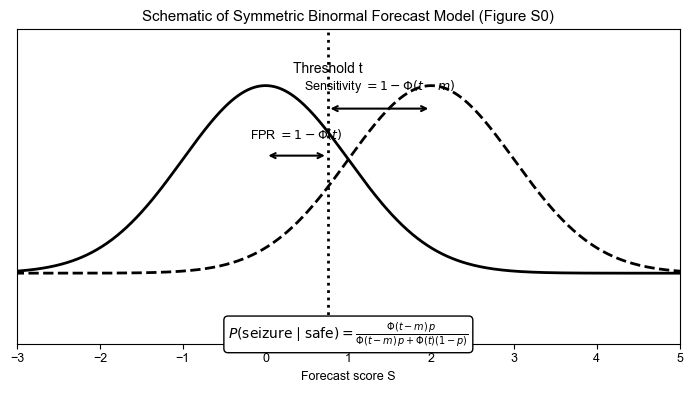

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for schematic
m = 2.0        # example separation (AUC ≈ 0.92)
t = 0.75       # threshold for illustration
x = np.linspace(-4, 6, 500)

# Distributions
y_non = norm.pdf(x, 0, 1)
y_seiz = norm.pdf(x, m, 1)

fig, ax = plt.subplots(figsize=(7, 4))

# Plot the two Gaussians
ax.plot(x, y_non, color='black', linewidth=2, label='Non-seizure (N(0,1))')
ax.plot(x, y_seiz, color='black', linestyle='--', linewidth=2, label='Seizure (N(m,1))')

# Threshold line
ax.axvline(t, color='black', linestyle=':', linewidth=2)
ax.text(t, max(y_seiz)*1.05, 'Threshold t', ha='center', va='bottom', fontsize=10)

# Sensitivity arrow
ax.annotate(
    '', xy=(t, 0.35), xytext=(m, 0.35),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+m)/2, 0.38, r"Sensitivity $=1-\Phi(t-m)$", ha='center', va='bottom', fontsize=9)

# FPR arrow
ax.annotate(
    '', xy=(t, 0.25), xytext=(0, 0.25),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+0)/2, 0.28, r"FPR $=1-\Phi(t)$", ha='center', va='bottom', fontsize=9)

# Bayes box under curves
bayes_text = (
    r"$P(\text{seizure} \mid \text{safe}) = "
    r"\frac{\Phi(t-m)\, p}{\Phi(t-m)\, p + \Phi(t)(1-p)}$"
)

ax.text(
    1.0, -0.10, bayes_text,
    ha='center', va='top', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    transform=ax.transData
)

# Clean formatting
ax.set_ylim(-0.15, max(y_seiz)*1.3)
ax.set_xlim(-3, 5)
ax.set_yticks([])
ax.set_xlabel("Forecast score S")
ax.set_title("Schematic of Symmetric Binormal Forecast Model (Figure S0)")

plt.tight_layout()

# Save all formats
fig.savefig("Figure_S4.pdf", bbox_inches='tight')

plt.show()


Verifying AUCs for each model shape:

  Equal-variance binormal: AUC = 0.900
  Unequal-variance (S-shaped): AUC = 0.918


  Mixture model (hooked): AUC = 0.887

=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===
=== Driving duration: 1.0 hour(s)/day ===

1 seizure / week (baseline seizure prob = 0.1331)
------------------------------------------------------------
Equal-variance binormal:
   FPR = 0.496, Sensitivity = 0.964
   Days in warning/year: 203.8
   Days allowed to drive/year: 161.2

Unequal-variance (S-shaped):
   FPR = 0.615, Sensitivity = 0.973
   Days in warning/year: 241.8
   Days allowed to drive/year: 123.2



Mixture model (hooked):
   FPR = 0.839, Sensitivity = 0.989
   Days in warning/year: 313.5
   Days allowed to drive/year: 51.5


1 seizure / month (baseline seizure prob = 0.0328)
------------------------------------------------------------
Equal-variance binormal:
   FPR = 0.105, Sensitivity = 0.713
   Days in warning/year: 45.7
   Days allowed to drive/year: 319.3

Unequal-variance (S-shaped):
   FPR = 0.046, Sensitivity = 0.694
   Days in warning/year: 24.4
   Days allowed to drive/year: 340.6



Mixture model (hooked):
   FPR = 0.096, Sensitivity = 0.710
   Days in warning/year: 42.2
   Days allowed to drive/year: 322.8


1 seizure / year (baseline seizure prob = 0.0027)
------------------------------------------------------------
Equal-variance binormal:
   FPR = 0.000, Sensitivity = 0.000
   Days in warning/year: 0.0
   Days allowed to drive/year: 365.0

Unequal-variance (S-shaped):
   FPR = 0.000, Sensitivity = 0.000
   Days in warning/year: 0.0
   Days allowed to drive/year: 365.0



Mixture model (hooked):
   FPR = 0.000, Sensitivity = 0.000
   Days in warning/year: 0.0
   Days allowed to drive/year: 365.0




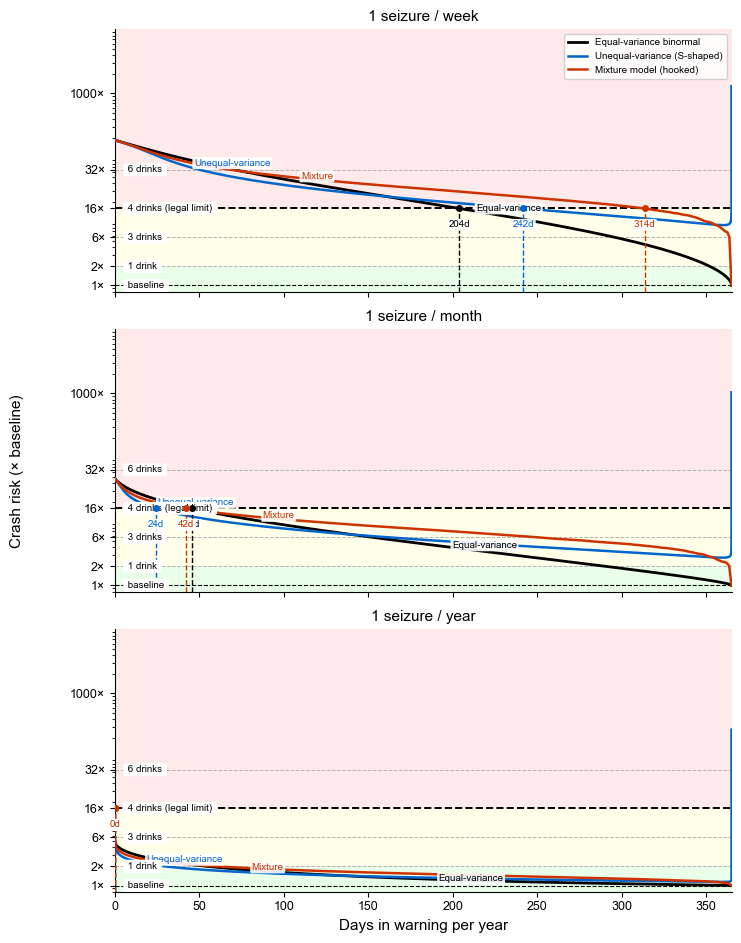

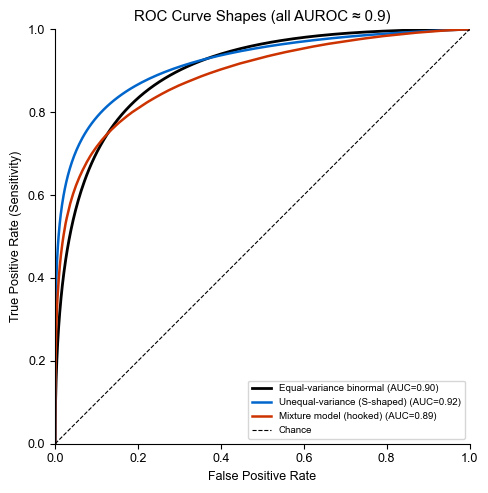

In [6]:
# %% [markdown]
# # ROC Shape Sensitivity Analysis: Drink-Equivalent Crash Risk
# 
# Compares different ROC curve shapes (all with AUROC ≈ 0.9) using the same
# visualization as Figure 1, with crash risk expressed as drink equivalents.

# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

# Journal-friendly style
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
})

# %%
# -------------------------
# Configuration
# -------------------------
RNG_SEED = 12345
rng = np.random.default_rng(RNG_SEED)

# Seizure frequencies
R = [1/7, 1/30, 1/365]
R_labels = ['1 seizure / week', '1 seizure / month', '1 seizure / year']

# Reference crash risks (baseline sober risk p0)
p0 = 1.5e-5
p1 = p0 * 2**(0.02/0.02)   # 1 drink
p3 = p0 * 2**(0.05/0.02)   # 3 drinks
p4 = p0 * 2**(0.08/0.02)   # 4 drinks (legal limit)
p6 = p0 * 2**(0.12/0.02)   # 6 drinks

y_limits = [0.8, 1e4]
p_crash_given_seizure_while_driving = 0.5  # P(crash | seizure occurs while driving)

# Driving duration for this sensitivity analysis
# Using 1 hour as a representative middle-ground value
DRIVING_HOURS = 1.0  

# Target AUC for all models
TARGET_AUC = 0.90

# %%
# -------------------------
# ROC curve computation for different shapes
# -------------------------

def compute_curve_binormal_equal_var(auc, p_seizure, driving_hours, n_points=1000):
    """
    Equal-variance binormal model (standard symmetric ROC).
    Updated to include driving exposure in crash calculation.
    """
    m = np.sqrt(2) * norm.ppf(auc)
    th = np.linspace(-10, 10, n_points)
    
    sensitivity = norm.cdf(m - th)
    fpr = 1 - norm.cdf(th)
    
    # P(seizure | "safe" day) via Bayes
    num = norm.cdf(th - m) * p_seizure
    den = num + norm.cdf(th) * (1 - p_seizure)
    p_seiz_given_safe = num / den
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    # Updated crash model with driving exposure
    p_driving_at_seizure = driving_hours / 24
    p_crash_given_seizure_day = (p_driving_at_seizure * p_crash_given_seizure_while_driving 
                                  + (1 - p_driving_at_seizure) * p0)
    
    pc = p_seiz_given_safe * p_crash_given_seizure_day + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    return days_warning, pc_relative, sensitivity, fpr


def compute_curve_binormal_unequal_var(p_seizure, driving_hours, n_points=1000):
    """
    Unequal-variance binormal model (S-shaped ROC).
    
    Negatives ~ N(0, 1), Positives ~ N(mu, sigma) with sigma > 1.
    Parameters tuned to give AUC ≈ 0.90.
    """
    # Parameters tuned for AUC ~ 0.90
    mu_pos = 2.4
    sigma_pos = 1.4
    
    th = np.linspace(-8, 12, n_points)
    
    # Sensitivity = P(score > th | positive) = 1 - Phi((th - mu_pos)/sigma_pos)
    sensitivity = 1 - norm.cdf((th - mu_pos) / sigma_pos)
    # FPR = P(score > th | negative) = 1 - Phi(th)
    fpr = 1 - norm.cdf(th)
    
    # P(score < th | positive) = Phi((th - mu_pos)/sigma_pos)
    # P(score < th | negative) = Phi(th)
    p_below_th_pos = norm.cdf((th - mu_pos) / sigma_pos)
    p_below_th_neg = norm.cdf(th)
    
    # P(seizure | safe day) = P(seizure | score < th)
    num = p_below_th_pos * p_seizure
    den = num + p_below_th_neg * (1 - p_seizure)
    p_seiz_given_safe = num / den
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    # Updated crash model with driving exposure
    p_driving_at_seizure = driving_hours / 24
    p_crash_given_seizure_day = (p_driving_at_seizure * p_crash_given_seizure_while_driving 
                                  + (1 - p_driving_at_seizure) * p0)
    
    pc = p_seiz_given_safe * p_crash_given_seizure_day + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    return days_warning, pc_relative, sensitivity, fpr


def compute_curve_mixture_positive(p_seizure, driving_hours, n_sim=500_000):
    """
    Mixture model in positive class (hooked ROC).
    
    Negatives ~ N(0, 1)
    Positives ~ mixture: 70% N(mu_easy, 1) + 30% N(mu_hard, 1)
    
    This creates a "hooked" ROC that rises quickly then flattens.
    Parameters tuned for AUC ~ 0.90.
    """
    # Parameters tuned for AUC ~ 0.90
    mu_easy = 2.5
    mu_hard = 0.8
    w_easy = 0.7
    
    # Simulate to get empirical ROC
    neg = rng.normal(0, 1, n_sim)
    pos = np.where(
        rng.random(n_sim) < w_easy,
        rng.normal(mu_easy, 1, n_sim),
        rng.normal(mu_hard, 1, n_sim)
    )
    
    # Compute ROC by sweeping thresholds
    all_scores = np.concatenate([neg, pos])
    thresholds = np.percentile(all_scores, np.linspace(100, 0, 500))
    
    sensitivity = np.array([np.mean(pos > th) for th in thresholds])
    fpr = np.array([np.mean(neg > th) for th in thresholds])
    
    # For each threshold, compute P(seizure | safe)
    p_below_pos = np.array([np.mean(pos <= th) for th in thresholds])
    p_below_neg = np.array([np.mean(neg <= th) for th in thresholds])
    
    num = p_below_pos * p_seizure
    den = num + p_below_neg * (1 - p_seizure)
    with np.errstate(divide='ignore', invalid='ignore'):
        p_seiz_given_safe = np.where(den > 0, num / den, 0)
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    # Updated crash model with driving exposure
    p_driving_at_seizure = driving_hours / 24
    p_crash_given_seizure_day = (p_driving_at_seizure * p_crash_given_seizure_while_driving 
                                  + (1 - p_driving_at_seizure) * p0)
    
    pc = p_seiz_given_safe * p_crash_given_seizure_day + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    # Compute AUC for verification
    order = np.argsort(fpr)
    auc = np.trapz(sensitivity[order], fpr[order])
    
    return days_warning, pc_relative, sensitivity, fpr, auc


# %%
# -------------------------
# Define model configurations
# -------------------------

# Colors and styles for each ROC shape
model_configs = [
    {
        "name": "Equal-variance binormal",
        "compute_func": lambda p, dh: compute_curve_binormal_equal_var(TARGET_AUC, p, dh),
        "color": "black",
        "linewidth": 2.0,
    },
    {
        "name": "Unequal-variance (S-shaped)",
        "compute_func": lambda p, dh: compute_curve_binormal_unequal_var(p, dh),
        "color": "#0066cc",  # blue
        "linewidth": 1.8,
    },
    {
        "name": "Mixture model (hooked)",
        "compute_func": lambda p, dh: compute_curve_mixture_positive(p, dh)[:4],  # exclude AUC return
        "color": "#cc3300",  # red
        "linewidth": 1.8,
    },
]

# %%
# -------------------------
# Verify AUCs
# -------------------------
print("Verifying AUCs for each model shape:\n")

test_p = 0.02  # arbitrary seizure prob for verification
for cfg in model_configs:
    dw, pc, sens, fpr_arr = cfg["compute_func"](test_p, DRIVING_HOURS)
    order = np.argsort(fpr_arr)
    auc = np.trapz(sens[order], fpr_arr[order])
    print(f"  {cfg['name']}: AUC = {auc:.3f}")

print()

# %%
# -------------------------
# Figure: Crash risk vs warning days (drink equivalents)
# -------------------------

fig, axes = plt.subplots(3, 1, figsize=(7.5, 9.5), sharex=True)

print('=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===')
print(f'=== Driving duration: {DRIVING_HOURS} hour(s)/day ===\n')

for j, (r, ax) in enumerate(zip(R, axes)):
    # Baseline daily seizure probability (Poisson process)
    p_seizure = 1 - np.exp(-r)
    print(f'{R_labels[j]} (baseline seizure prob = {p_seizure:.4f})')
    print('-' * 60)

    # Colored bands
    ax.axhspan(p4/p0, y_limits[1], facecolor='#ffcccc', alpha=0.4, zorder=0)  # unsafe
    ax.axhspan(p1/p0, p4/p0, facecolor='#ffffcc', alpha=0.4, zorder=0)        # caution
    ax.axhspan(y_limits[0], p1/p0, facecolor='#ccffcc', alpha=0.4, zorder=0)  # safe

    # Reference lines
    ax.axhline(y=1,     color='k',     linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(y=p1/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p3/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p4/p0, color='black', linestyle='--', linewidth=1.4, zorder=2)
    ax.axhline(y=p6/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)

    crossing_info = []

    for cfg in model_configs:
        days_warn, pc_rel, sens, fpr_arr = cfg["compute_func"](p_seizure, DRIVING_HOURS)
        
        # Sort by days_warning
        order = np.argsort(days_warn)
        days_warn = days_warn[order]
        pc_rel = pc_rel[order]
        sens = sens[order]
        fpr_arr = fpr_arr[order]
        
        # Plot curve
        ax.plot(days_warn, pc_rel,
                color=cfg["color"], linewidth=cfg["linewidth"], zorder=3)

        # Find crossing point at legal limit
        idx_cross = np.where(pc_rel < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            dw_cross = days_warn[idx_cross]
            s_cross = sens[idx_cross]
            f_cross = fpr_arr[idx_cross]
            
            crossing_info.append((dw_cross, cfg["name"], s_cross, f_cross, cfg["color"]))
            
            # Stats
            p_warning_cross = s_cross * p_seizure + f_cross * (1 - p_seizure)
            p_safe_cross = 1 - p_warning_cross
            days_driving = p_safe_cross * 365
            
            print(f'{cfg["name"]}:')
            print(f'   FPR = {f_cross:.3f}, Sensitivity = {s_cross:.3f}')
            print(f'   Days in warning/year: {dw_cross:.1f}')
            print(f'   Days allowed to drive/year: {days_driving:.1f}')
            print()
        else:
            print(f'{cfg["name"]}: Cannot reach legal-limit threshold\n')

        # Label the curve near its median x position
        mid_idx = np.argmin(np.abs(days_warn - np.median(days_warn)))
        label_offset = 1.0
        ax.text(days_warn[mid_idx] + 10, pc_rel[mid_idx] * label_offset,
                cfg["name"].split()[0],  # Short name
                fontsize=7, ha='left', va='center', color=cfg["color"],
                bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                          edgecolor='none', alpha=0.9), zorder=5)

    # Plot crossing markers
    for dw_cross, name, s_cross, f_cross, color in crossing_info:
        ax.plot([dw_cross, dw_cross], [y_limits[0], p4/p0],
                '--', color=color, linewidth=1.0, zorder=4)
        ax.plot(dw_cross, p4/p0, 'o', color=color, markersize=4, zorder=7)
        ax.text(dw_cross, p4/p0 * 0.65, f'{dw_cross:.0f}d',
                fontsize=7, ha='center', va='top', color=color,
                bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                          edgecolor='none', alpha=0.9), zorder=8)

    # Panel formatting
    ax.set_ylim(y_limits)
    ax.set_xlim([0, 365])
    ax.set_yscale('log')
    ax.set_title(R_labels[j], fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Drink labels
    ax.text(6, 1,      ' baseline ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p1/p0,  ' 1 drink ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p3/p0,  ' 3 drinks ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p4/p0,  ' 4 drinks (legal limit) ',fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p6/p0,  ' 6 drinks ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)

    # Y-ticks as multiples
    ax.set_yticks([1, p1/p0, p3/p0, p4/p0, p6/p0, 1e3])
    ax.set_yticklabels(['1×', '2×', '6×', '16×', '32×', '1000×'])
    
    # Legend only on first panel
    if j == 0:
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=cfg["color"], linewidth=cfg["linewidth"], 
                   label=cfg["name"])
            for cfg in model_configs
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=7, framealpha=0.9)

    print()

# Shared labels
fig.text(0.02, 0.5, 'Crash risk (× baseline)', va='center',
         rotation='vertical', fontsize=11)
axes[-1].set_xlabel('Days in warning per year', fontsize=11)

plt.tight_layout()
plt.subplots_adjust(left=0.16)

fig.savefig('Figure_S6.pdf', facecolor='white', bbox_inches='tight')
fig.savefig('Figure_S6.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

# %%
# -------------------------
# Companion: Show the actual ROC curves
# -------------------------

fig, ax = plt.subplots(figsize=(5, 5))

# Use a fixed seizure prob just to generate the ROC curves for display
p_test = 0.02

for cfg in model_configs:
    dw, pc, sens, fpr_arr = cfg["compute_func"](p_test, DRIVING_HOURS)
    order = np.argsort(fpr_arr)
    auc = np.trapz(sens[order], fpr_arr[order])
    
    ax.plot(fpr_arr[order], sens[order],
            color=cfg["color"], linewidth=cfg["linewidth"],
            label=f'{cfg["name"]} (AUC={auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=0.8, label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('ROC Curve Shapes (all AUROC ≈ 0.9)')
ax.legend(loc='lower right', fontsize=7)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_aspect('equal')

fig.tight_layout()
fig.savefig('Figure_S6.pdf', facecolor='white', bbox_inches='tight')
fig.savefig('Figure_S6.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

# %% [markdown]
# ## Summary
# 
# PDFs saved:
# - `Figure_S6.pdf` - Main figure (drink-equivalent visualization, 1 hr driving/day)
# - `Figure_S6.pdf` - ROC curves for reference

# Extended AUC Table for Main Text

This cell calculates the comprehensive table showing driving restrictions for all AUC values: 0.60, 0.70, 0.80, 0.90, 0.95, 0.99.

The table can be copied directly into Microsoft Word.

In [7]:
# -------------------------
# Extended AUC Table Calculation
# -------------------------

# Extended AUC values for comprehensive table
auc_values_extended = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Driving durations
driving_hours_list = [0.5, 1.0, 2.0]
driving_labels = {0.5: '30 min driving/day', 1.0: '1 hour driving/day', 2.0: '2 hours driving/day'}

# Store results for table
results_extended = []

print('=' * 90)
print('EXTENDED AUC ANALYSIS: Driving Restrictions Required for Legal-Limit Safety')
print('=' * 90)
print()

for driving_hours in driving_hours_list:
    print()
    print('#' * 90)
    print(f'# {driving_labels[driving_hours]}')
    print(f'# P(driving at seizure time) = {driving_hours}/24 = {driving_hours/24:.4f}')
    print('#' * 90)
    print()
    
    for r, label in zip(R, R_labels):
        p = 1 - np.exp(-r)
        print(f'{label} (daily seizure probability = {p:.4f})')
        print('-' * 80)
        
        for auc in auc_values_extended:
            dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p, driving_hours)
            
            # Sort for cross detection
            idx_sort = np.argsort(dw)
            dw_sorted = dw[idx_sort]
            pc_sorted = pc_rel[idx_sort]
            s_sorted = s_ana[idx_sort]
            f_sorted = f_ana[idx_sort]
            
            # Find crossing point at legal limit
            idx_cross = np.where(pc_sorted < p4/p0)[0]
            if len(idx_cross) > 0:
                idx_cross = idx_cross[0]
                dw_cross = dw_sorted[idx_cross]
                s_cross = s_sorted[idx_cross]
                f_cross = f_sorted[idx_cross]
                
                p_warning_cross = s_cross * p + f_cross * (1 - p)
                p_safe = 1 - p_warning_cross
                days_driving = p_safe * 365
                avg_interval = 1 / p_safe if p_safe > 0 else np.inf
                
                results_extended.append({
                    'driving_hours': driving_hours,
                    'freq': label,
                    'auc': auc,
                    'warning': dw_cross,
                    'driving': days_driving,
                    'interval': avg_interval
                })
                
                print(f'  AUC = {auc:.2f}:')
                print(f'    Warning days/year: {dw_cross:6.1f}')
                print(f'    Driving days/year: {days_driving:6.1f}')
                print(f'    Avg interval:      {avg_interval:6.1f} days')
            else:
                results_extended.append({
                    'driving_hours': driving_hours,
                    'freq': label,
                    'auc': auc,
                    'warning': None,
                    'driving': None,
                    'interval': None
                })
                print(f'  AUC = {auc:.2f}: Cannot reach legal-limit safety threshold')
            print()
        print()

# -------------------------
# Print formatted tables for Word
# -------------------------
print('=' * 90)
print('TABLES FOR MICROSOFT WORD (Tab-delimited)')
print('=' * 90)
print()
print('Copy each table below and paste into Word using "Keep Text Only",')
print('then convert to table via: Table → Convert Text to Table → Tabs')
print()

for driving_hours in driving_hours_list:
    print()
    print('=' * 90)
    print(f'TABLE: {driving_labels[driving_hours]}')
    print('=' * 90)
    print()
    print('-' * 80)
    print('Seizure Frequency\tAUC\tWarning Days/Year\tDriving Days/Year\tAvg Days Between Drives')
    print('-' * 80)
    
    for r_label in R_labels:
        freq_results = [r for r in results_extended 
                        if r['freq'] == r_label and r['driving_hours'] == driving_hours]
        for i, res in enumerate(freq_results):
            if i == 0:
                freq_col = res['freq']
            else:
                freq_col = ''
            
            auc_str = f"{res['auc']:.2f}"
            
            if res['warning'] is None:
                warning_str = '—'
                driving_str = '—'
                interval_str = 'Cannot reach safety threshold'
            else:
                warning_str = f"{res['warning']:.0f}"
                driving_str = f"{res['driving']:.0f}"
                # Format interval nicely
                if res['interval'] > 1e6:
                    interval_str = '∞'
                elif res['interval'] > 10000:
                    interval_str = f"{res['interval']:,.0f}"
                else:
                    interval_str = f"{res['interval']:.1f}"
            
            print(f'{freq_col}\t{auc_str}\t{warning_str}\t{driving_str}\t{interval_str}')
    
    print('-' * 80)
    print()

print()
print('Table title suggestion:')
print('  "Driving Restrictions Required to Achieve Legal-Limit Crash Risk')
print('   by Seizure Frequency, Driving Duration, and Forecasting Performance"')
print()
print('=' * 90)

EXTENDED AUC ANALYSIS: Driving Restrictions Required for Legal-Limit Safety


##########################################################################################
# 30 min driving/day
# P(driving at seizure time) = 0.5/24 = 0.0208
##########################################################################################

1 seizure / week (daily seizure probability = 0.1331)
--------------------------------------------------------------------------------
  AUC = 0.60:
    Warning days/year:  365.0
    Driving days/year:    0.0
    Avg interval:      5828507.1 days

  AUC = 0.70:
    Warning days/year:  356.0
    Driving days/year:    9.0
    Avg interval:        40.4 days

  AUC = 0.80:
    Warning days/year:  268.7
    Driving days/year:   96.3
    Avg interval:         3.8 days

  AUC = 0.90:
    Warning days/year:  138.0
    Driving days/year:  227.0
    Avg interval:         1.6 days

  AUC = 0.95:
    Warning days/year:   80.8
    Driving days/year:  284.2
    Avg interval:  